# Transformer Translation
---

#### environment setting

In [134]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!
import sentencepiece as spm


print(tf.__version__)

2.4.1


## Step 1. 데이터 다운로드
---

[jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)에서 한국어-영어 병렬 데이터를 다운로드 받는다.

- 다운로드 경로 지정

In [4]:
workspace_path = '/home/aiffel-dj1/workspace/aiffel-gd-nlp/GD10_transformer_translation'
data_path = '/home/aiffel-dj1/workspace/aiffel-gd-nlp/GD08_seq2seq_translation/data'

- 다운로드

In [5]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz -P $data_path

--2021-05-04 16:04:01--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 15.164.81.167
접속 github.com (github.com)|15.164.81.167|:443... 접속됨.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2021-05-04 16:04:01--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
접속 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘/home/aiffel-dj1/workspace/aiffel-gd-nlp/GD08_seq2seq_translation/data/korean

- 압축 풀기

In [6]:
!gzip -d $data_path/korean-english-park.train.tar.gz
!tar -xvf $data_path/korean-english-park.train.tar -C $data_path

gzip: /home/aiffel-dj1/workspace/aiffel-gd-nlp/GD08_seq2seq_translation/data/korean-english-park.train.tar already exists; do you wish to overwrite (y or n)? ^C
korean-english-park.train.en
korean-english-park.train.ko


In [7]:
!ls $data_path

korean-english-park.dev.en    korean-english-park.train.en
korean-english-park.dev.ko    korean-english-park.train.ko
korean-english-park.dev.tar   korean-english-park.train.tar
korean-english-park.test.en   korean-english-park.train.tar.gz
korean-english-park.test.ko   sp_train_corpus_en.temp
korean-english-park.test.tar  sp_train_corpus_ko.temp


## Step 2. 데이터 정제 및 토큰화
---

### A. 중복 제거

`set`을 활용하여 데이터의 중복을 제거한다.

In [71]:
def get_duplicated_index(raw):
    clear_set = set()
    removed_index = []
    cnt_old = 0
    
    for i, sen in enumerate(raw):
        clear_set.add(sen)
        cnt_new = len(clear_set)
        
        if cnt_new == cnt_old:
            removed_index.append(i)
        cnt_old = cnt_new
    
    return removed_index

In [72]:
def remove_by_indexs(raw, indexs):
    return [ sen for i, sen in enumerate(raw) if i not in indexs ]

In [73]:
kor_path = data_path + "/korean-english-park.train.ko"
eng_path = data_path + "/korean-english-park.train.en"

def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    removed_index = get_duplicated_index(kor)
    clean_corpus_ko = remove_by_indexs(kor, removed_index)
    clean_corpus_en = remove_by_indexs(eng, removed_index)
    
    removed_index = get_duplicated_index(clean_corpus_en)
    clean_corpus_en = remove_by_indexs(clean_corpus_en, removed_index)
    clean_corpus_ko = remove_by_indexs(clean_corpus_ko, removed_index)

    return clean_corpus_ko, clean_corpus_en

clean_corpus_ko, clean_corpus_en = clean_corpus(kor_path, eng_path)

- 데이터 확인

In [74]:
len(clean_corpus_ko), len(clean_corpus_en)

(74849, 74849)

In [75]:
idx = np.random.choice(len(cleaned_corpus), 5)
for i in idx:
    print(f'{i}')
    print(f'ko >>> {clean_corpus_ko[i]}')
    print(f'en >>> {clean_corpus_en[i]}\n')

44616
ko >>> 무어는 “마침내 룸메이트가 농담을 했고 조는 웃음을 보였다”고 덧붙였다.
en >>> Finally, Moore's roommate cracked a joke and Cho laughed. Moore didn't take offense to Cho's silence.

10392
ko >>> 프란시스코 비달 칠레 정부 대변인은 CNN과의 인터뷰에서 구조선 5척을 동원해 차이텐 및 부근 도시에 거주하는 주민, 기자, 구호요원을 안전한 곳으로 옮길 것이라고 말했다.
en >>> Five boats will transport the remaining emergency officials, reporters, residents and others from the town, government spokesman Francisco Vidal told CNN en Espanol.

60948
ko >>> 2000년 처음으로 김대중 ?
en >>> The first and only inter-Korean summit between Kim and North Korean leader Kim Jong-il in 2000 opened the doors for a flurry of economic, cultural and political reconciliation projects such as the Kaesong industrial park in the North Korean border town and tourism programs to the North’s Mount Kumgang.

59428
ko >>> 이번 결정은 디트로이트가 16경기 시즌에서 단 1승도 못 올리는 최초의 NFL 팀이 된 지 하루 만에 나온 것입니다. 월가 소식입니다.
en >>> This comes just one day after Detroit became the first NFL team ever to go winless in a 16-game season.

63610
ko 

### B. 데이터 정제

주어진 데이터를 다음의 조건에 맞추어 정제함수를 작성한다.
- 모든 입력을 소문자로 변환한다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거한다.
- 문장부호 양옆에 공백을 추가한다.
- 문장 앞뒤의 불필요한 공백을 제거한다.

In [76]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅣ가-힣?.!,]+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

### C. tokenizer

Sentencepiece를 활용하여 토큰화를 진행하며 tokenizer 생성 함수(generate_tokenizer)를 정의하고, 한국어와 영어 tokenizer를 생성한다.

생성 함수는 다음 조건을 따라 정의한다.

- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 한다. (기본: 20,000)
- 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환한다.
- 특수 토큰의 인덱스를 아래와 동일하게 지정한다.
    - `<PAD>` : 0
    - `<BOS>` : 1
    - `<EOS>` : 2
    - `<UNK>` : 3

In [77]:
model_path = workspace_path + '/model'

In [78]:
def generate_tokenizer(corpus,
                        vocab_size=20000,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    corpus_path = f'{data_path}/sp_train_corpus_{lang}.temp'
    with open(corpus_path, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')

    prefix = f'{model_path}/spm_{lang}'
    
    spm.SentencePieceTrainer.Train(
        f'--input={corpus_path} \
            --model_prefix={prefix} \
            --vocab_size={vocab_size} \
            --model_type=unigram \
            --pad_id={pad_id} \
            --bos_id={bos_id} \
            --eos_id={eos_id} \
            --unk_id={unk_id}')
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')

    return tokenizer

In [79]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for k, e in zip(clean_corpus_ko, clean_corpus_en):
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

- kor tokenizer 테스트

In [80]:
examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

In [87]:
for sen in examples:
    sen = preprocess_sentence(sen)
    encoded = ko_tokenizer.EncodeAsIds(sen)
    decoded = ko_tokenizer.DecodeIds(encoded)
    print(f'raw data : {sen}')
    print(f'encoded : {encoded}')
    print(f'decoded : {decoded}\n')

raw data : 오바마는 대통령이다 .
encoded : [94, 7, 237, 28, 4]
decoded : 오바마는 대통령이다 .

raw data : 시민들은 도시 속에 산다 .
encoded : [2285, 9, 567, 2118, 663, 28, 4]
decoded : 시민들은 도시 속에 산다 .

raw data : 커피는 필요 없다 .
encoded : [3074, 7, 760, 216, 4]
decoded : 커피는 필요 없다 .

raw data : 일곱 명의 사망자가 발생했다 .
encoded : [23, 19875, 79, 637, 11, 430, 4]
decoded : 일곱 명의 사망자가 발생했다 .



- eng tokenizer 테스트


In [88]:
examples_en = [
    "Obama is President.",
    "Citizens live in cities.",
    "I don't need coffee.",
    "Seven people were killed."
]

In [89]:
for sen in examples_en:
    print(f'raw data : {sen}')
    sen = preprocess_sentence(sen)
    encoded = en_tokenizer.EncodeAsIds(sen)
    decoded = en_tokenizer.DecodeIds(encoded)
    print(f'encoded : {encoded}')
    print(f'decoded : {decoded}\n')

raw data : Obama is President.
encoded : [1, 144, 25, 52, 7, 2]
decoded : obama is president .

raw data : Citizens live in cities.
encoded : [1, 1360, 582, 13, 666, 50, 7, 2]
decoded : citizens live in cities .

raw data : I don't need coffee.
encoded : [1, 56, 407, 60, 247, 3021, 7, 2]
decoded : i don t need coffee .

raw data : Seven people were killed.
encoded : [1, 504, 55, 44, 165, 9, 7, 2]
decoded : seven people were killed .



### D. 토큰화

토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환한다.

In [90]:
from tqdm import tqdm_notebook

src_corpus = []
tgt_corpus = []
max_len = 50

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    ko_tokenized = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    en_tokenized = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(ko_tokenized) <= max_len and len(en_tokenized) <= max_len:
        src_corpus.append(ko_tokenized)
        tgt_corpus.append(en_tokenized)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/74849 [00:00<?, ?it/s]

- 데이터 확인

In [91]:
len(enc_train), len(dec_train)

(64260, 64260)

In [92]:
idx = np.random.choice(len(enc_train), 3)

In [93]:
for i in idx:
    print(i)
    print(f'ko encoded : {enc_train[i]}')
    print(f'ko decoded : {ko_tokenizer.DecodeIds(enc_train[i].tolist())}')
    print(f'en encoded : {dec_train[i]}')
    print(f'en decoded : {en_tokenizer.DecodeIds(dec_train[i].tolist())}\n')

32672
ko encoded : [  393     9  1959    11   864     9   939   215   682     6 18007    15
    46     4     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
ko decoded : 성명은 블레어가 이같은 문제에 큰 관심을 보여왔다고 전했다 .
en encoded : [   1 1049  205    5   10  211  465    5  733  349  744    2    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
en decoded : create plans to help palestinians develop economically

37761
ko encoded : [  488    22  2961  6910    70 11373    28     4     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0    

## Step 3. 모델 설계
---

Transformer의 내부 모듈을 구현하고 이를 조립하여 모델을 설계하여 보자.

![transformer](https://paul-hyun.github.io/assets/2019-12-19/transformer-model-architecture.png)

### A. 내부 모듈 정의

#### Positional Encoding

In [246]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i, d_model):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position, d_model):
        return [cal_angle(position, i, d_model) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i, d_model) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

#### Multi-Head Attention

In [247]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        matmul_qk = tf.matmul(Q, K, transpose_b=True)
        dk = tf.cast(K.shape[-1], tf.float32)
        scaled_qk = matmul_qk / tf.math.sqrt(dk)
        
#         print('scaled_dot_product_attention')
#         print(f'Q.shape : {Q.shape}')
#         print(f'K.shape : {K.shape}')
#         print(f'V.shape : {V.shape}')
#         print(f'mask.shape : {mask.shape}')
#         print(f'scaled_qk.shape : {scaled_qk.shape}')
        if mask is not None: 
            scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
#         print(f'attentions.shape : {attentions.shape}')
        out = tf.matmul(attentions, V)
#         print(f'out.shape : {out.shape}\n')

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

#### Position-wise Feed-Forward Network

In [248]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### B. Encoder/Decoder  정의

#### Encoder Layer

In [249]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

#### Encoder

In [250]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

#### Decoder Layer

In [272]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

#### Decoder

In [273]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### C. Transformer 정의

In [274]:
class Transformer(tf.keras.Model):
    def __init__(self,
                n_layers,
                d_model,
                n_heads,
                d_ff,
                src_vocab_size,
                tgt_vocab_size,
                pos_len,
                dropout=0.2,
                shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
            self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

### D. Masking

In [275]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [276]:
def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

In [277]:
def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(src)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [278]:
def generate_masks(inp, tar):
    enc_padding_mask = generate_padding_mask(inp)
    dec_padding_mask = generate_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = generate_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

### E. Learning Rate Scheduler

In [279]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

## Step 4. 훈련하기
---

### A. Transformer

In [292]:
transformer = Transformer(n_layers=2, 
                          d_model=512, 
                          n_heads=8, 
                          d_ff=2048, 
                          src_vocab_size=SRC_VOCAB_SIZE, 
                          tgt_vocab_size=TGT_VOCAB_SIZE, 
                          pos_len=256, 
                          dropout=0.1)

### B. Optimizer

![optimizer](https://i.ibb.co/0Gr6Nqj/2021-05-04-09-02-14.png)

In [293]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### C. Loss function

In [294]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### D. Train step

In [295]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### E. Train

In [296]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=True, cbar_kws={"shrink": .5},
                        ax=ax,
                        xticklabels=x,
                        yticklabels=y,
                        cmap='GnBu')
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [297]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    ids = []
    
    output = tf.convert_to_tensor([tgt_tokenizer.bos_id()] + [tgt_tokenizer.pad_id()] * (enc_train.shape[-1] - 1), tf.int64)
    output = tf.expand_dims(output, 0)
#     output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
            _input, output)
        
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, 
                                                                 output,
                                                                 enc_padding_mask,
                                                                 combined_mask,
                                                                 dec_padding_mask)
        
        predictions = predictions[:, -1:, :]
        predicted_id = tf.argmax(predictions, axis=-1).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.convert_to_tensor([tgt_tokenizer.bos_id()] +
                                      ids + 
                                      [tgt_tokenizer.pad_id()] * (enc_train.shape[-1] - 1 - len(ids)), 
                                      tf.int64)
        output = tf.expand_dims(output, 0)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [298]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
        evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('🇰🇷 : %s' % (sentence))
    print('🇺🇸 : {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [299]:
# 학습
from tqdm.notebook import tqdm

BATCH_SIZE = 256
EPOCHS = 20

examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

In [300]:
def train(transformer, optimizer, enc_train, dec_train, 
          enc_tokenizer, dec_tokenizer,
          examples, EPOCHS=20, BATCH_SIZE=128):
    
    losses = []
    
    for epoch in range(EPOCHS):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(
                enc_train[idx:idx+BATCH_SIZE],
                dec_train[idx:idx+BATCH_SIZE],
                transformer,
                optimizer)

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
        for i, example in enumerate(examples):
            if (epoch + 1) % 10 == 0 and i == 0:
                translate(example, transformer, enc_tokenizer, dec_tokenizer, plot_attention=True)
            else:
                translate(example, transformer, enc_tokenizer, dec_tokenizer)
            
            
        losses.append(total_loss)
        
    return losses

In [301]:
def show_train_loss(losses):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(losses)
    ax.set_title('Traina loss', fontsize=15)
    plt.show()

- [TRT] EPOCH = 20

  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : the obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the the the the the the the the saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the the the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : the the  the  the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the the the the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : it it it it no it . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : cnn cnn cnn a . monda . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president president president president president president president president president president president president president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : cnn cnn cnn  cnn cnn  cnn  cnn cnn a police sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president president president president president president president president obama president obama president obama president obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the urban is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need need no need need no need . no . . . . . . . . no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the the the the the the . the . the . . . the . . . . . . . the . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . coffee . coffee . coffee coffee . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday a sunday sunday sunday sunday sunday


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama president president obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : urban cit cit cit urban cit cit cit cit . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee coffee coffee coffee no
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Encoder Layer 1


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


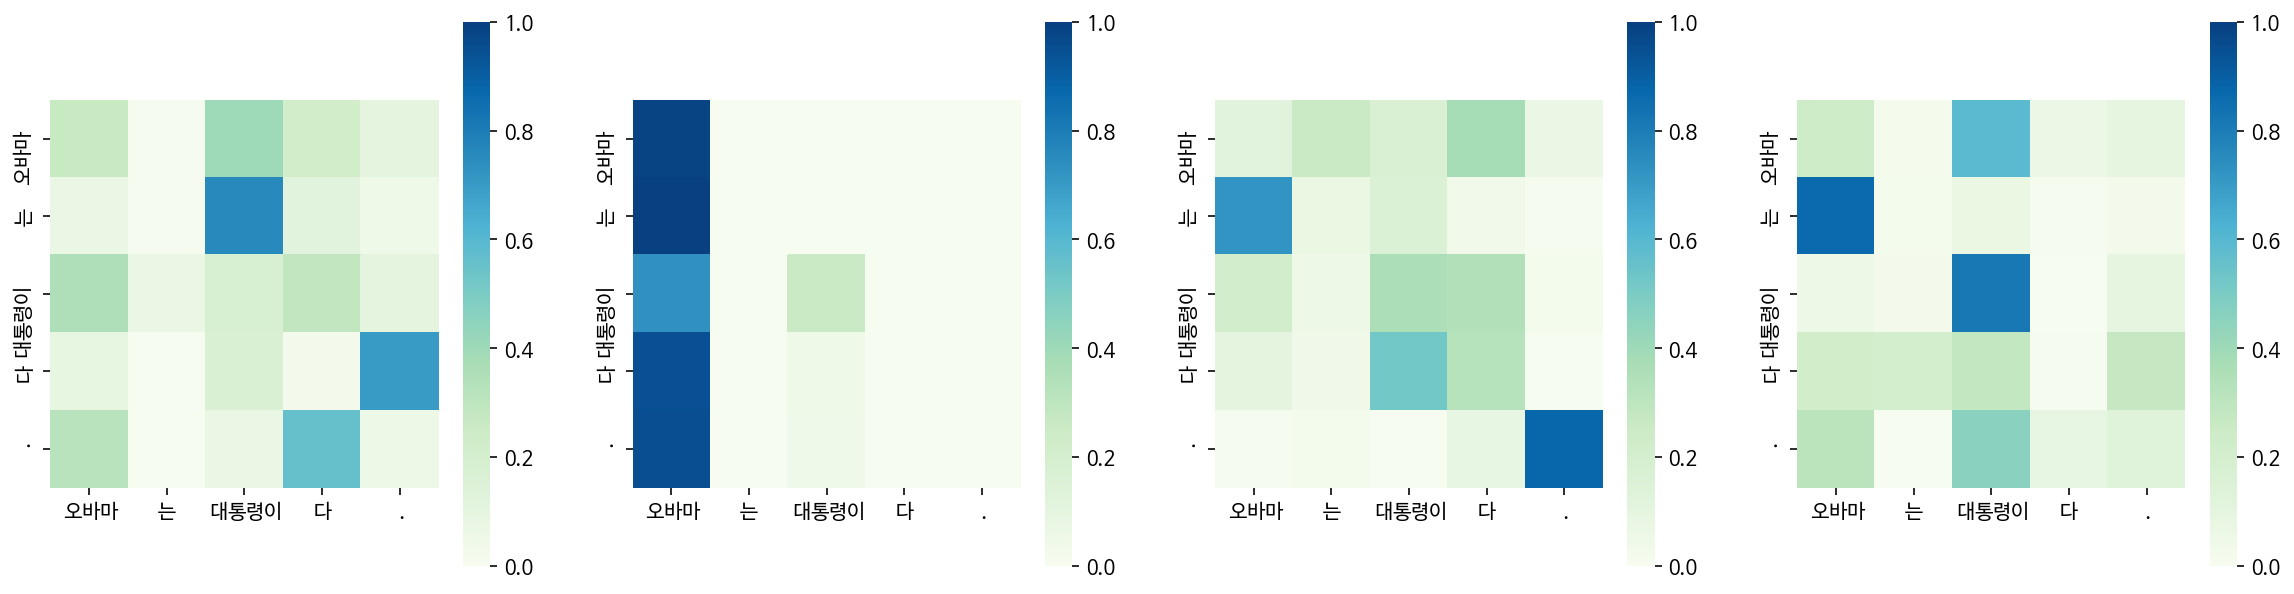

Encoder Layer 2


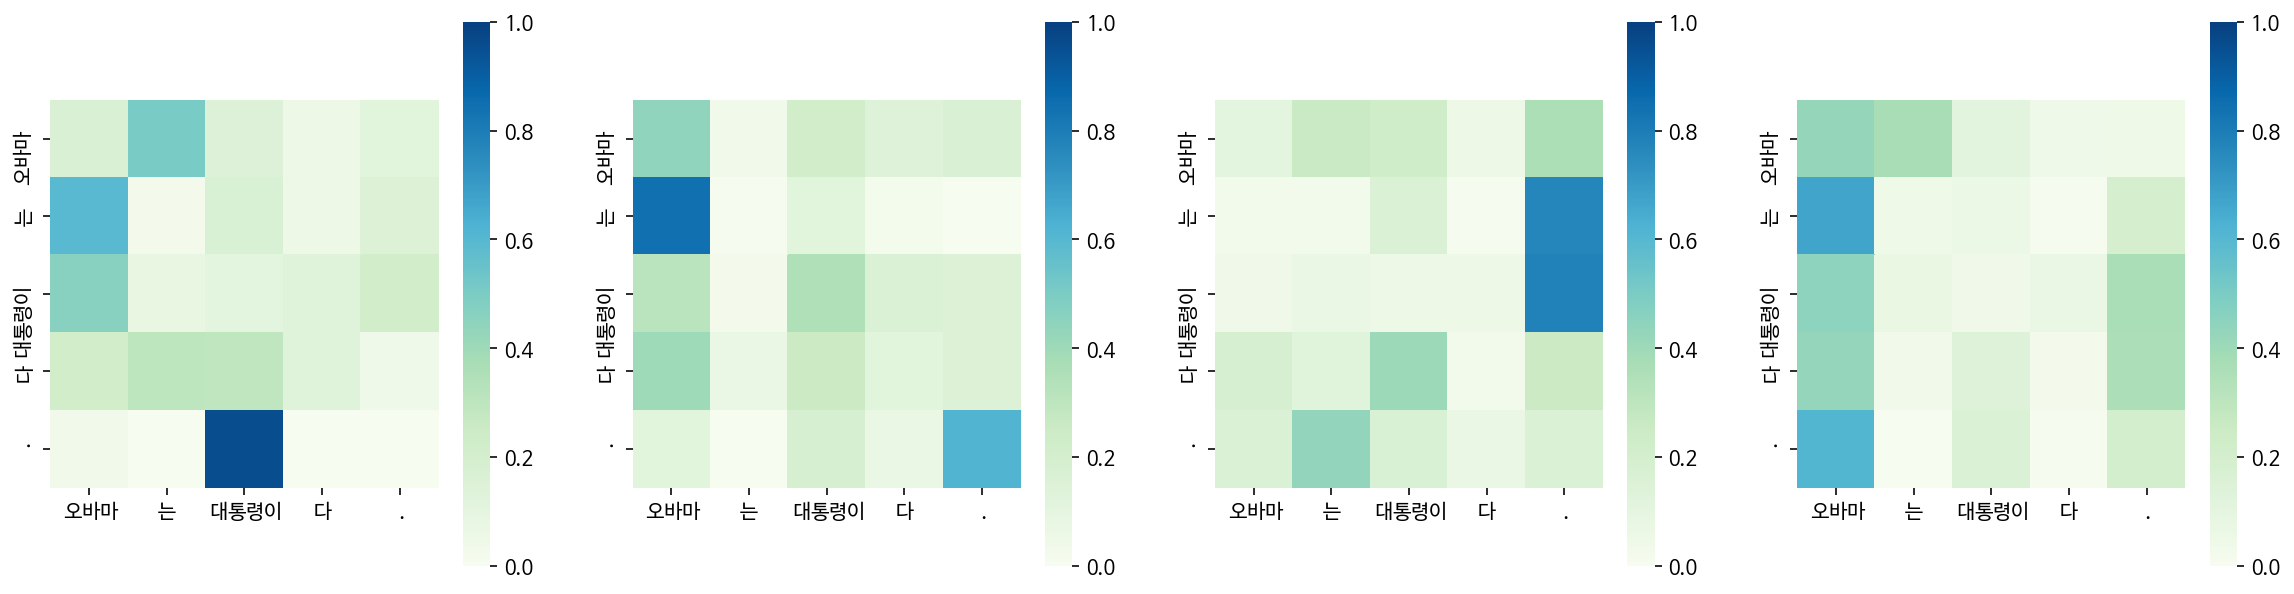

Decoder Self Layer 1


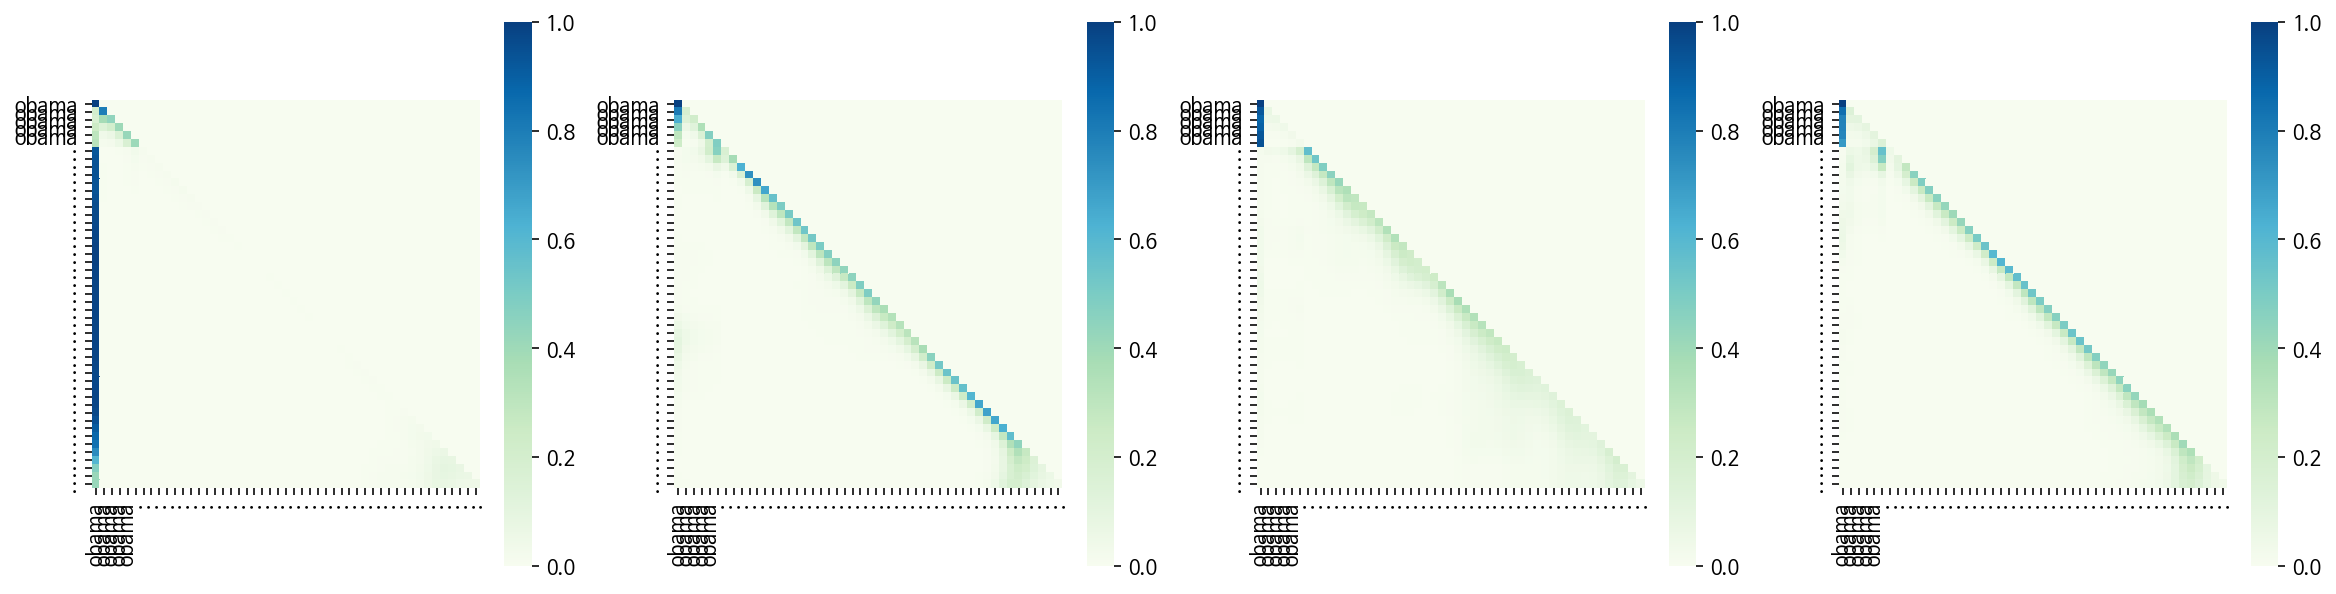

Decoder Src Layer 1


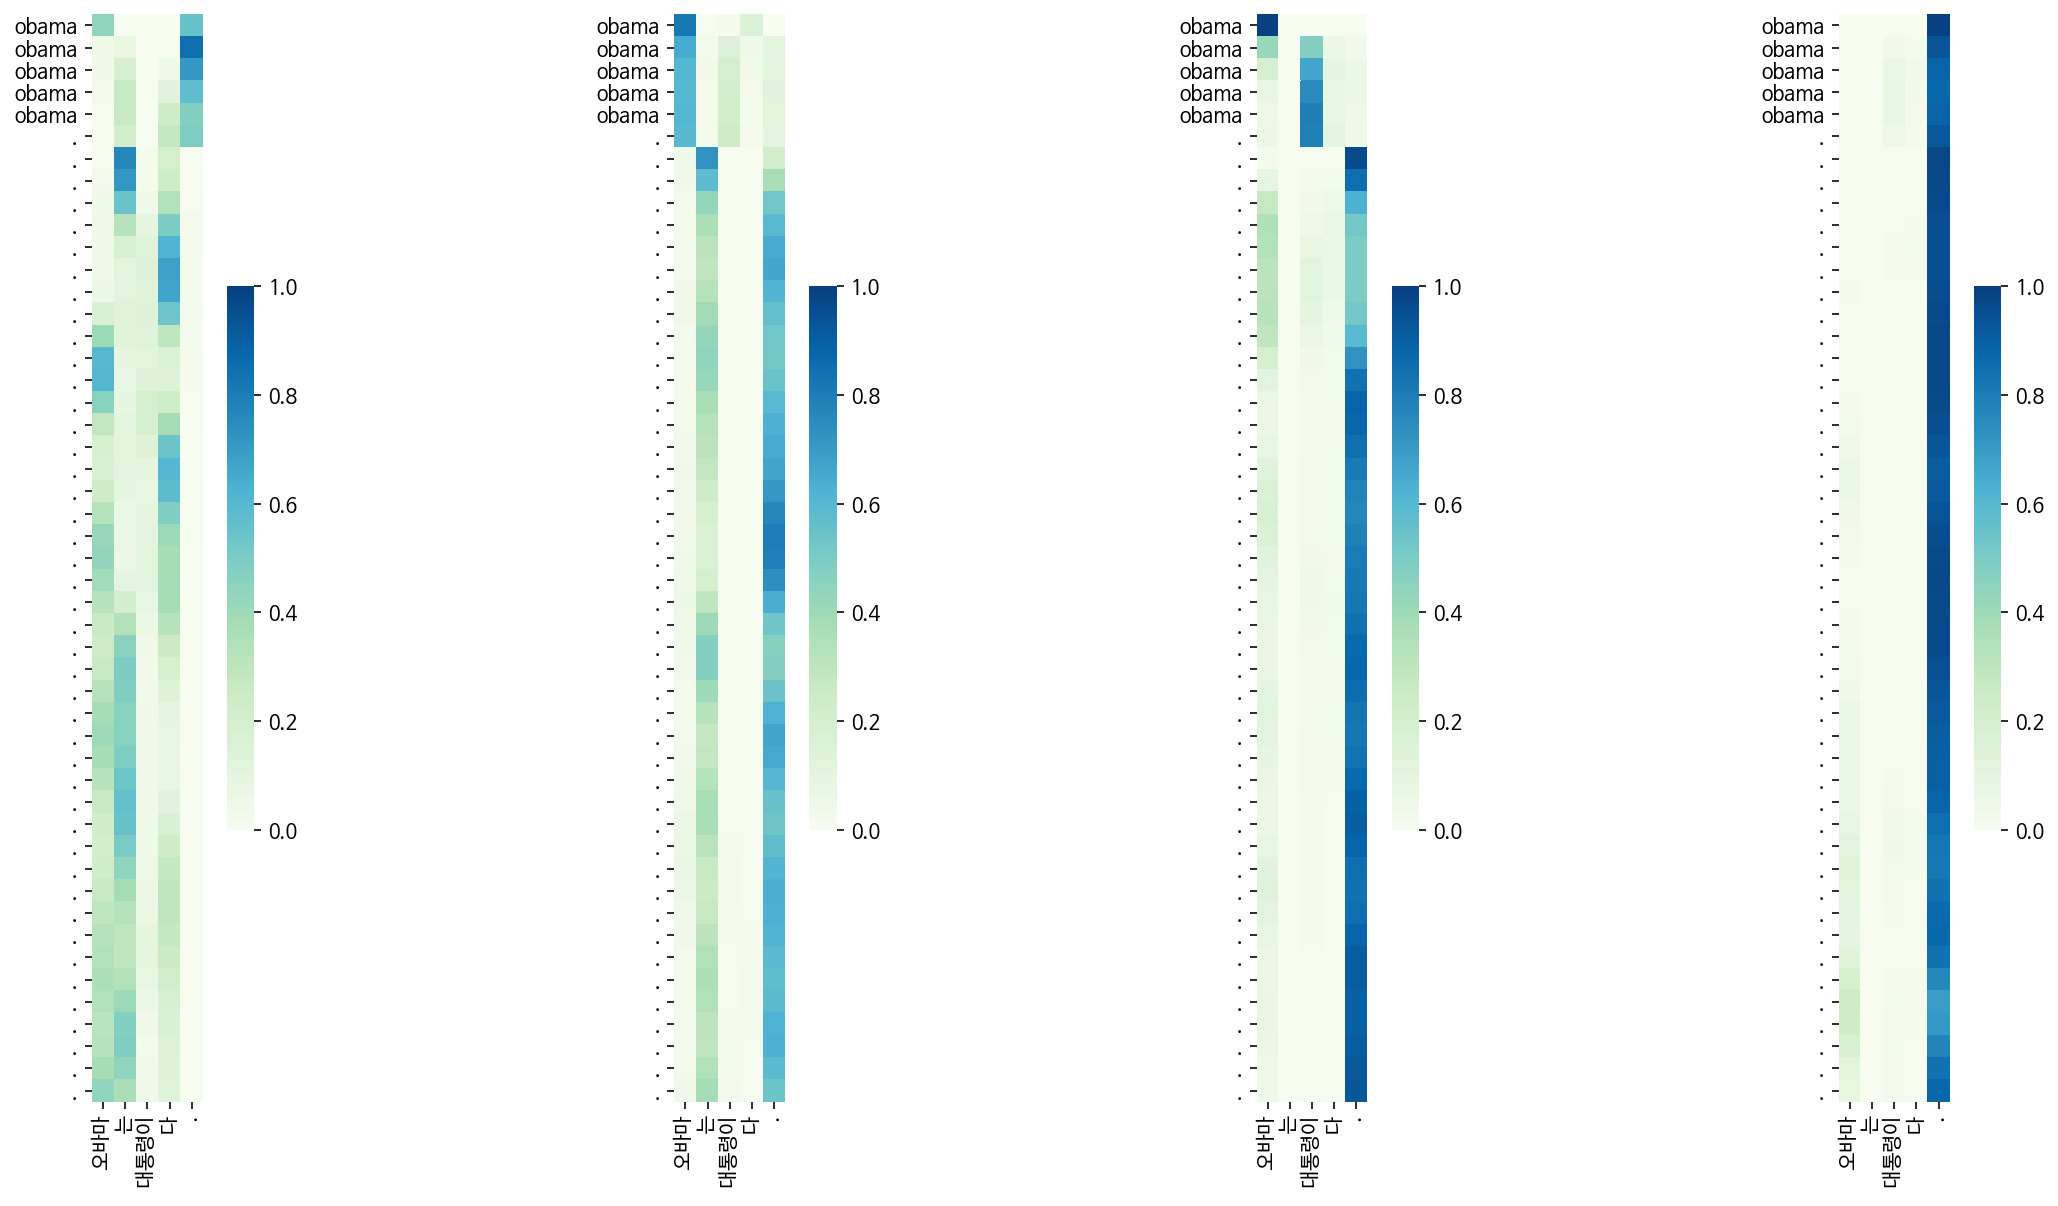

Decoder Self Layer 2


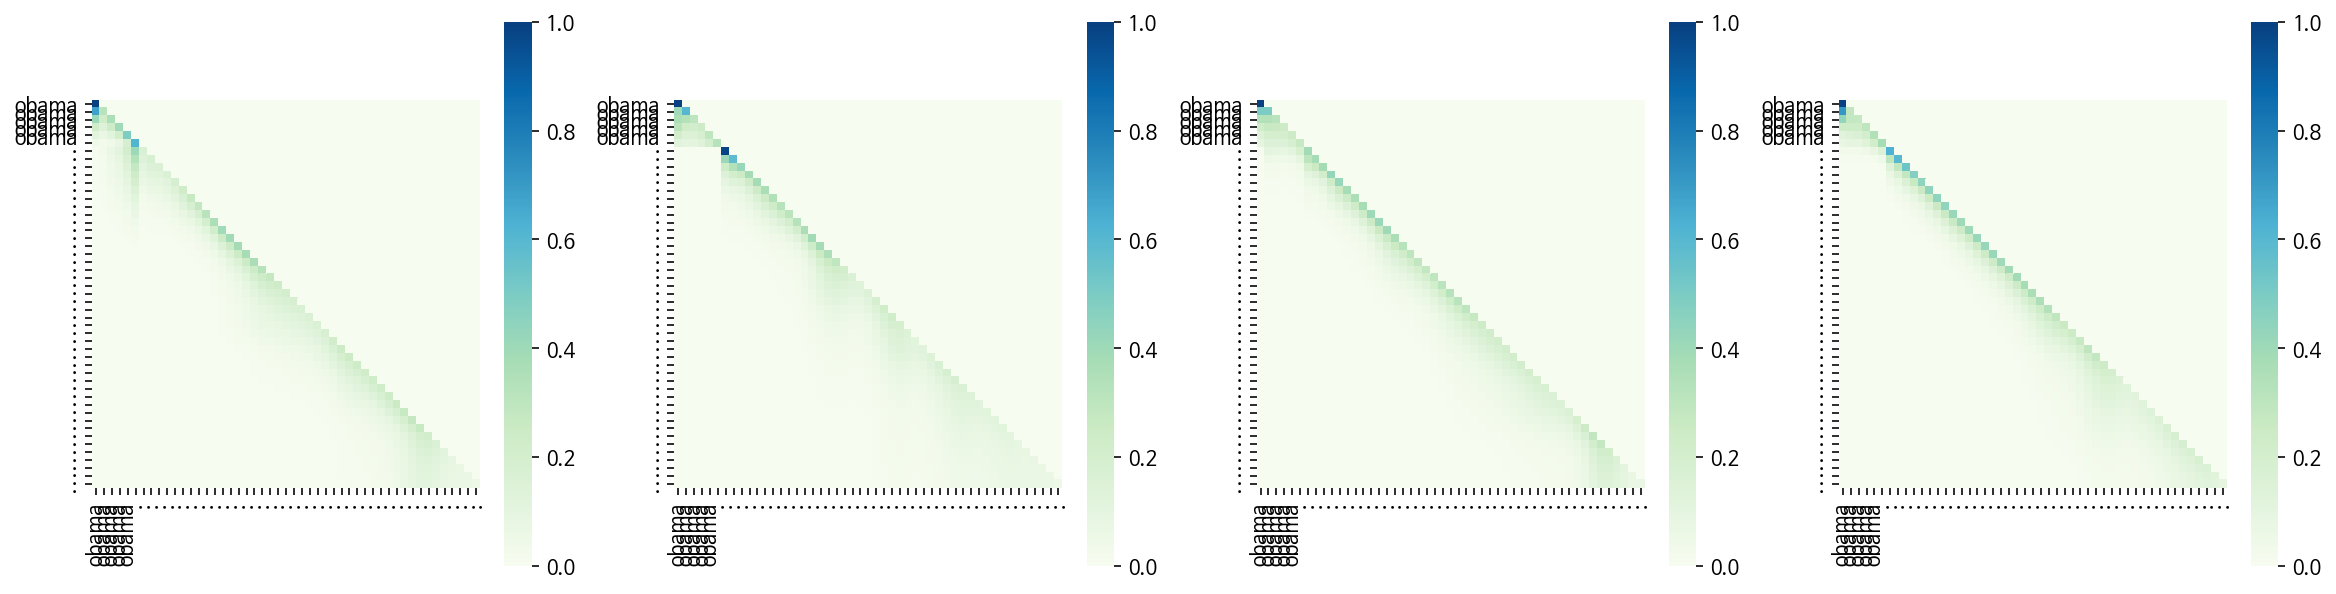

Decoder Src Layer 2


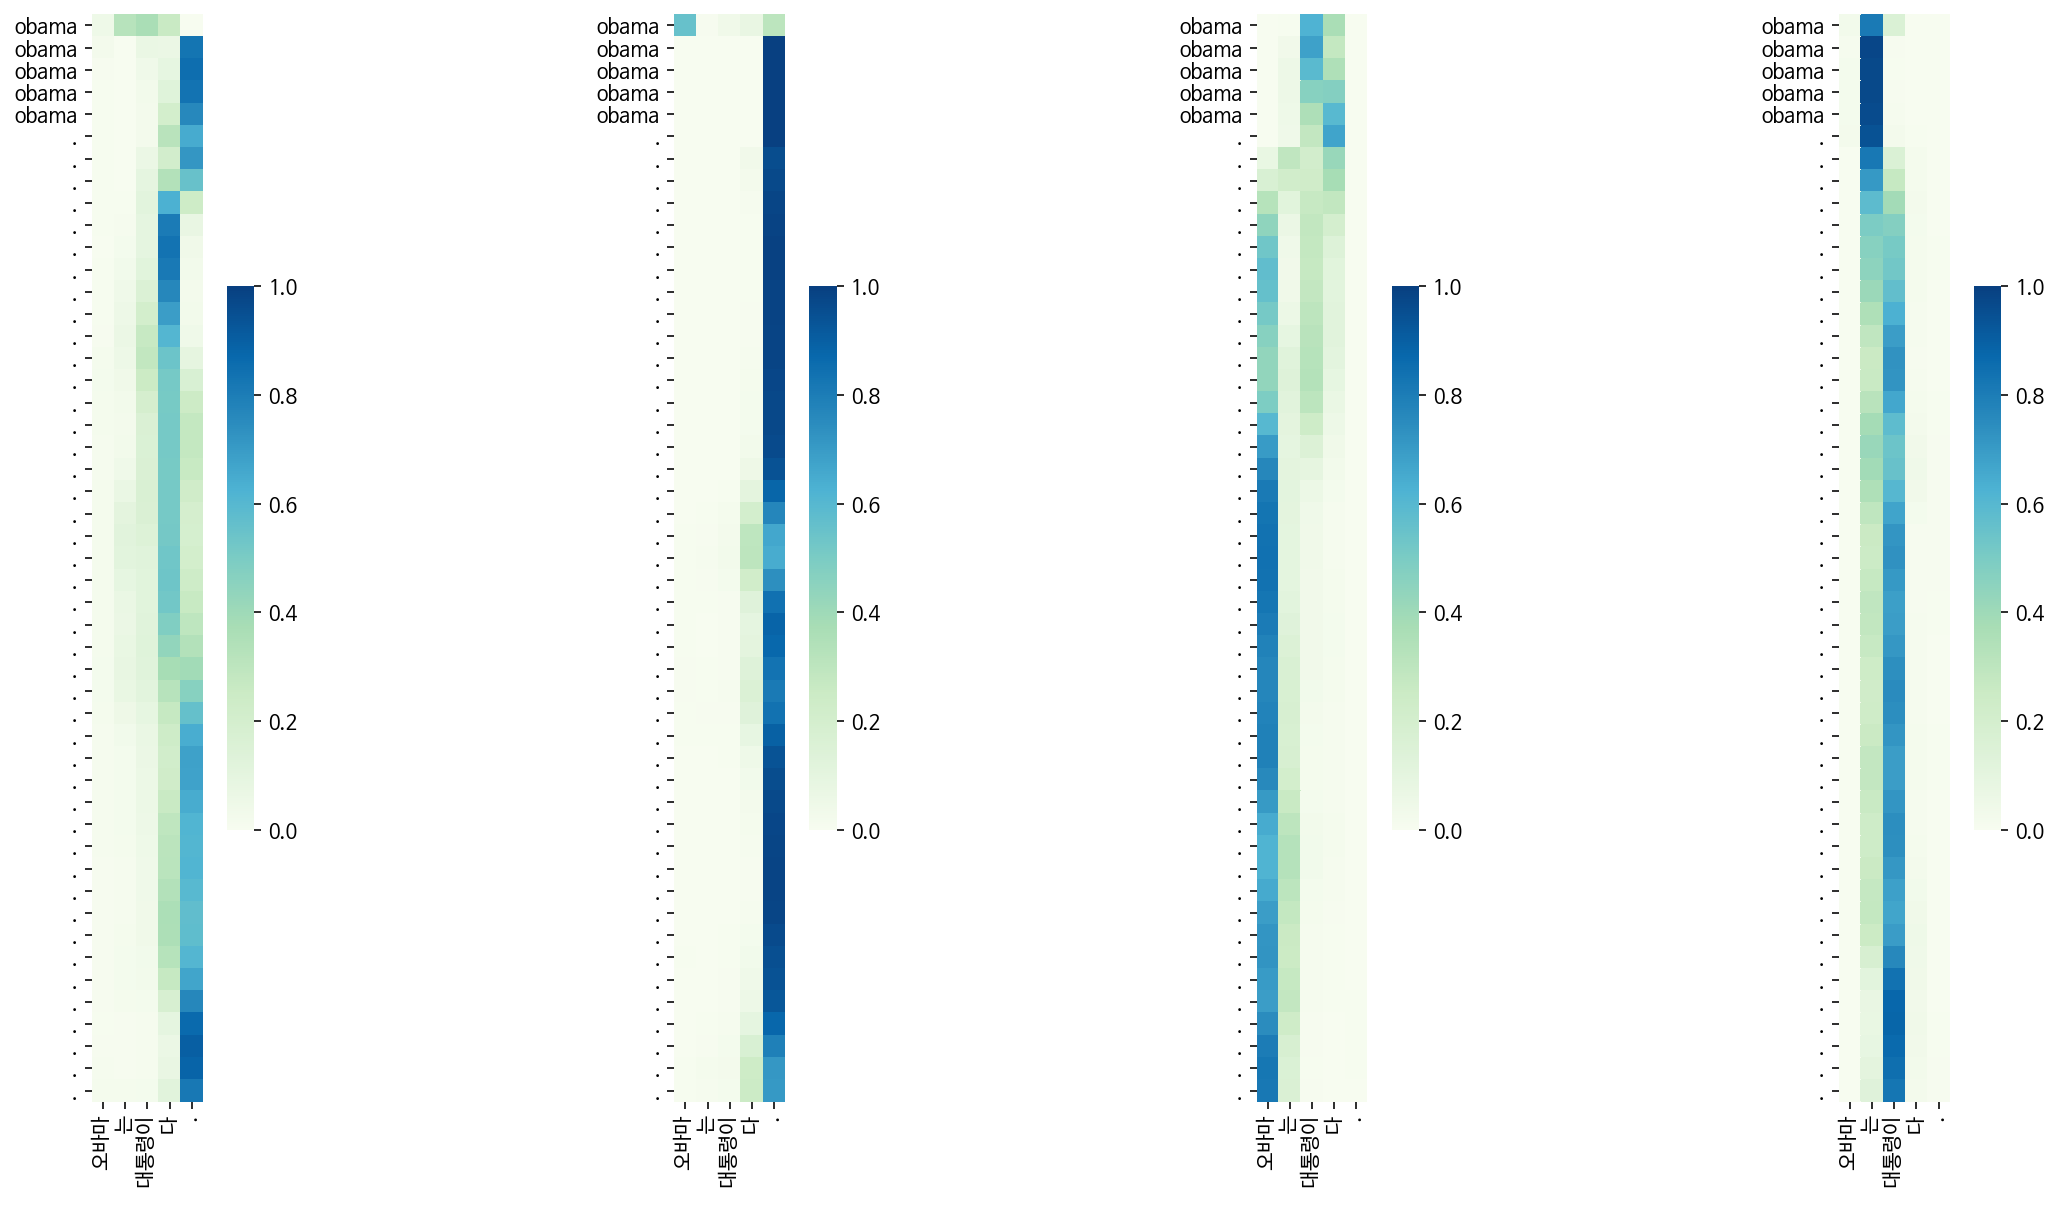

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the cit cit towns the the the the the is . . . . . . . . the . . . . . . the . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : you need need need need need need need need no need
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sunday sunday sunday sunday sunday sunday sunday sunday sunday


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama obama obama obama obama . obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : cit cit cit cit cit cit cit cit the cit cit cit this this city this . cit cit cit this cit
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven thursday thursday cnn seven cnn seven seven thursday thursday


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama transition transition . obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : urban urban urban urban urban urban urban . the psychological psychological
🇰🇷 : 커피는 필요 없다.
🇺🇸 : any need need need need need need need need need or need need need need need need need to need need need need need need need need need need need need need need need need need need to need need need . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sunday all them them thes . them . all them them the deads


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama campaign . obama obama obama . . . . . . . . . . . . . . obama . . . . . . . . . . . . . . . is . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : cit cit cit cit cit cit cit cit the is . the the the . the is . . . . . . the the . . . . there there is . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : any any any any coffee need need need need . no to
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the . all dead fatalit fatalits fatalitss and them them them them a them them them them them . them them them them them them . them . . . them . . the haveed themed . them . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama obama obama obama obama obama obama obama obama . is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : city city city city city city city city city city city city . city city city city city city city . . . the . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : any any any need need need . need for need need need need need . must need for need need need need need need need need . for need need need need need need . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : a .          .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : are . to to . . . . . . to . . . . . . . every . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee coffee coffee . coffee . coffee . coffee . . . . coffee . . . . . . . . . . . coffee . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven and injur were dead later injur . injur . injur      . . . . .s ands injurssss .s .s . . and them deadss . .s . . them . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . obama . . . . . . . . . obama . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : cit cit cit cit cit cit cit cit urban cit cit cit cit urban . mountain mountain is . . . . one . one one one one . is . . . . . . . in . . . . isr . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : any any necessar coffee . is . not . not . . entry . . entry . . . entry . . . . . . entry . . . . . . . . . . . not
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were dead  cnn cnn .  cnn dead cnn injur cnn injur injur cnns have dead deadss .ss        to   . . . temblor ofsed


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : urban is . . . . . . . . . . . . . to . . . . . . . town slide slide slide slide slide slide slide slide . . . .r is . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : don need need need need to need to need need to don need need . don need to need to don don . don don need to need . . cup . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven dead were sunday                        cnn


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people urban of urban of urban of . urban of urban .ss . . . . ofs . i . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : don sound sound sound sound sound sound sound sound destination application application application application application application application application application ifs application application application applications applications application applications . application application application applications
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven and . seven seven . . . seven . . seven . . . . . . . . . . . . . . . people haveed dead . .s . . .s .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people over schools schools schools . this this are . . . . . . of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no . . . . . . . . . . . don . . . . . . . . drink coffee . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven and . seven seven seven seven seven seven and . . . dead . . . . dead . . . . . . dead . dead . . dead and them dead . them . . . them . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama over president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Encoder Layer 1


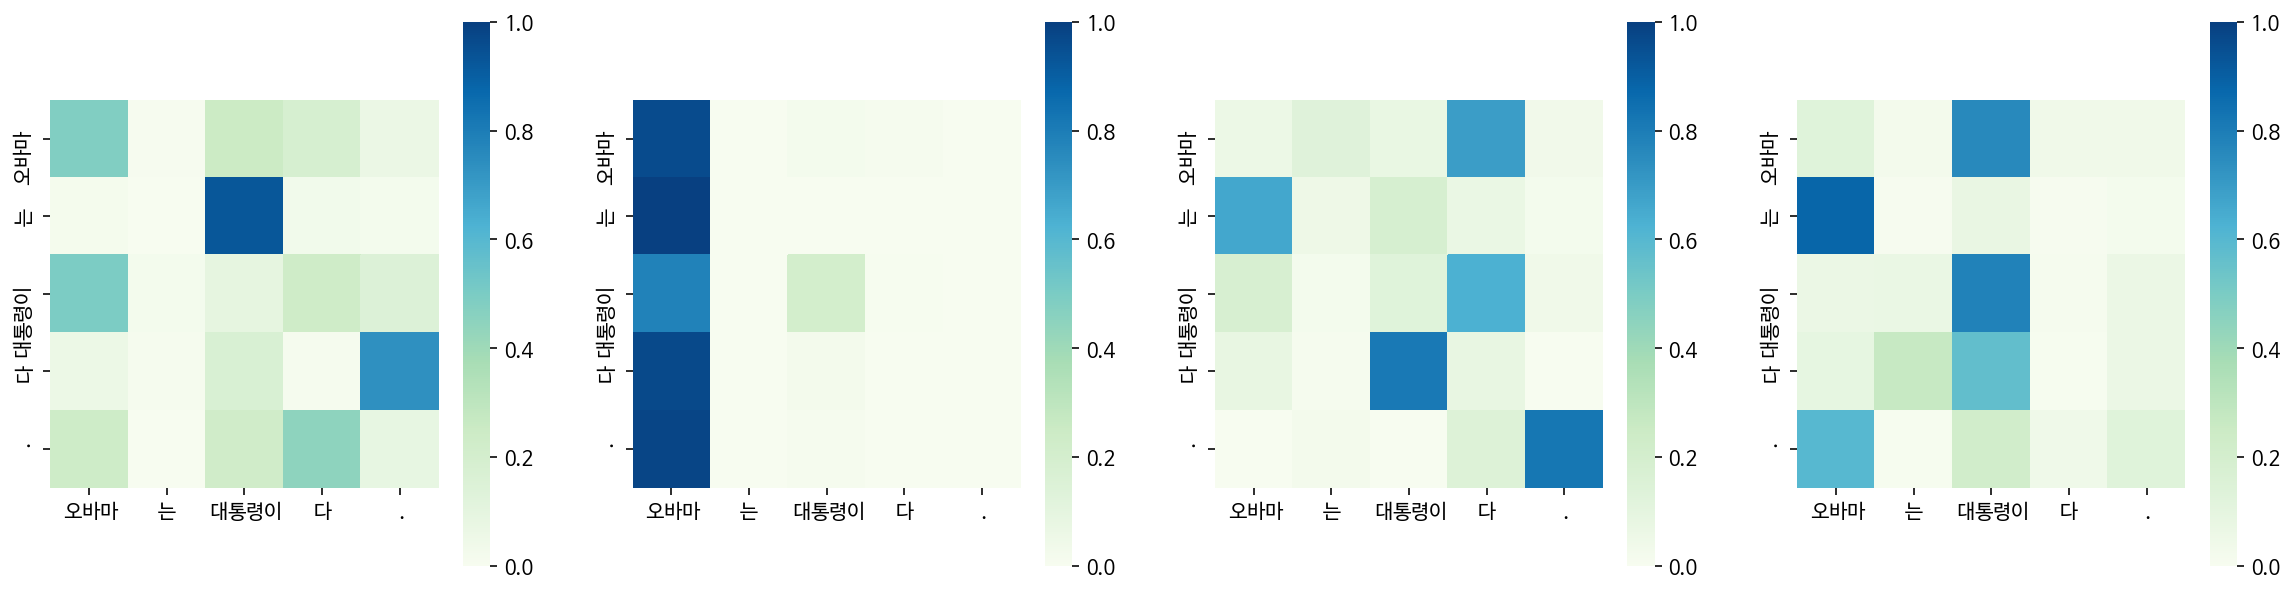

Encoder Layer 2


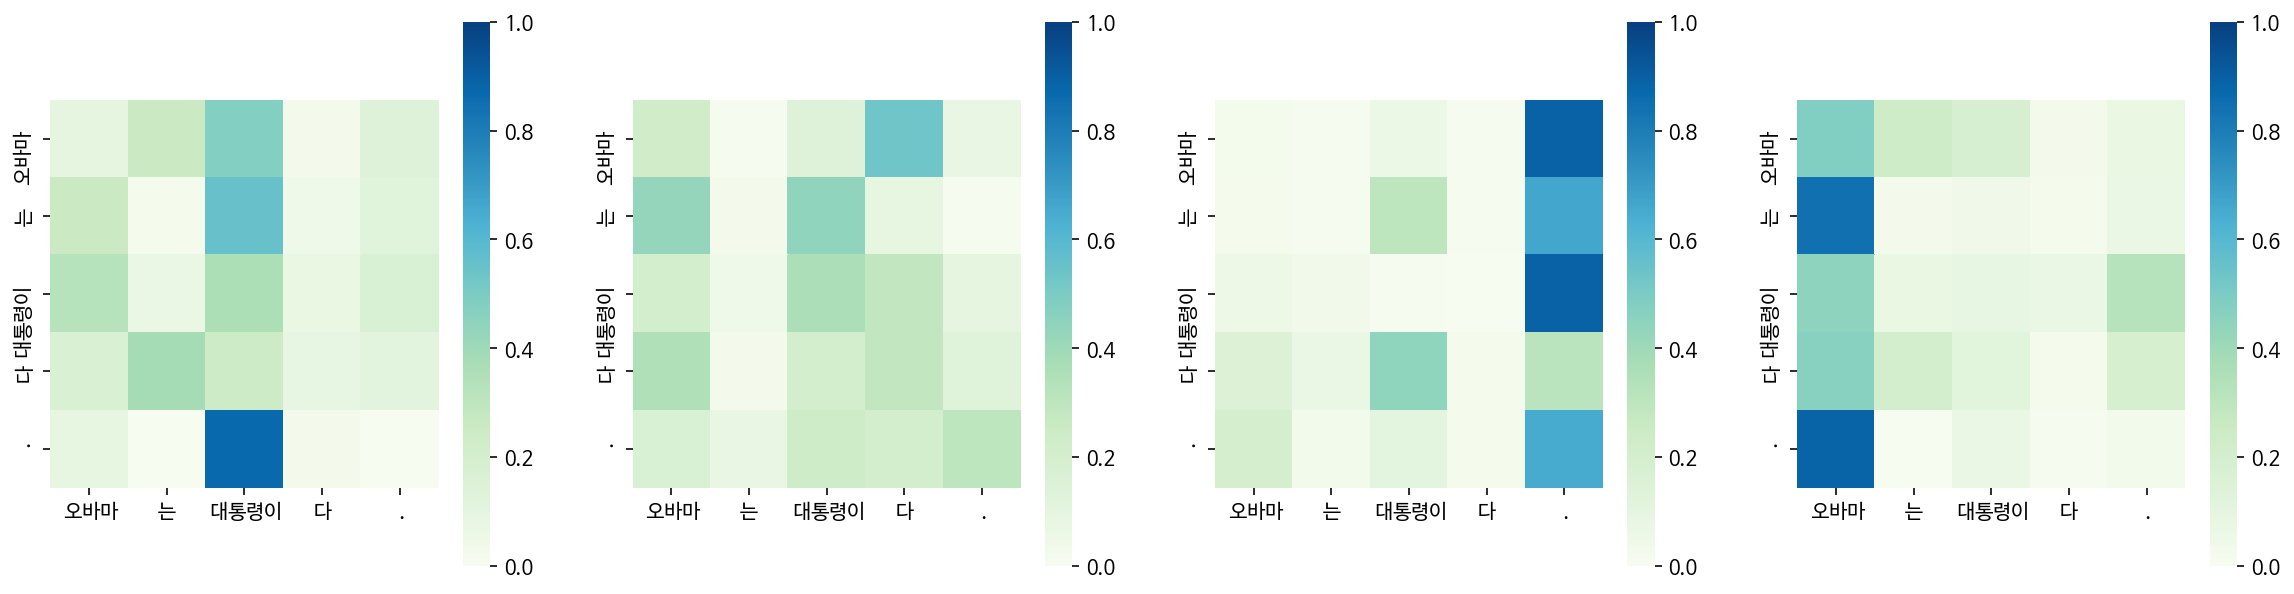

Decoder Self Layer 1


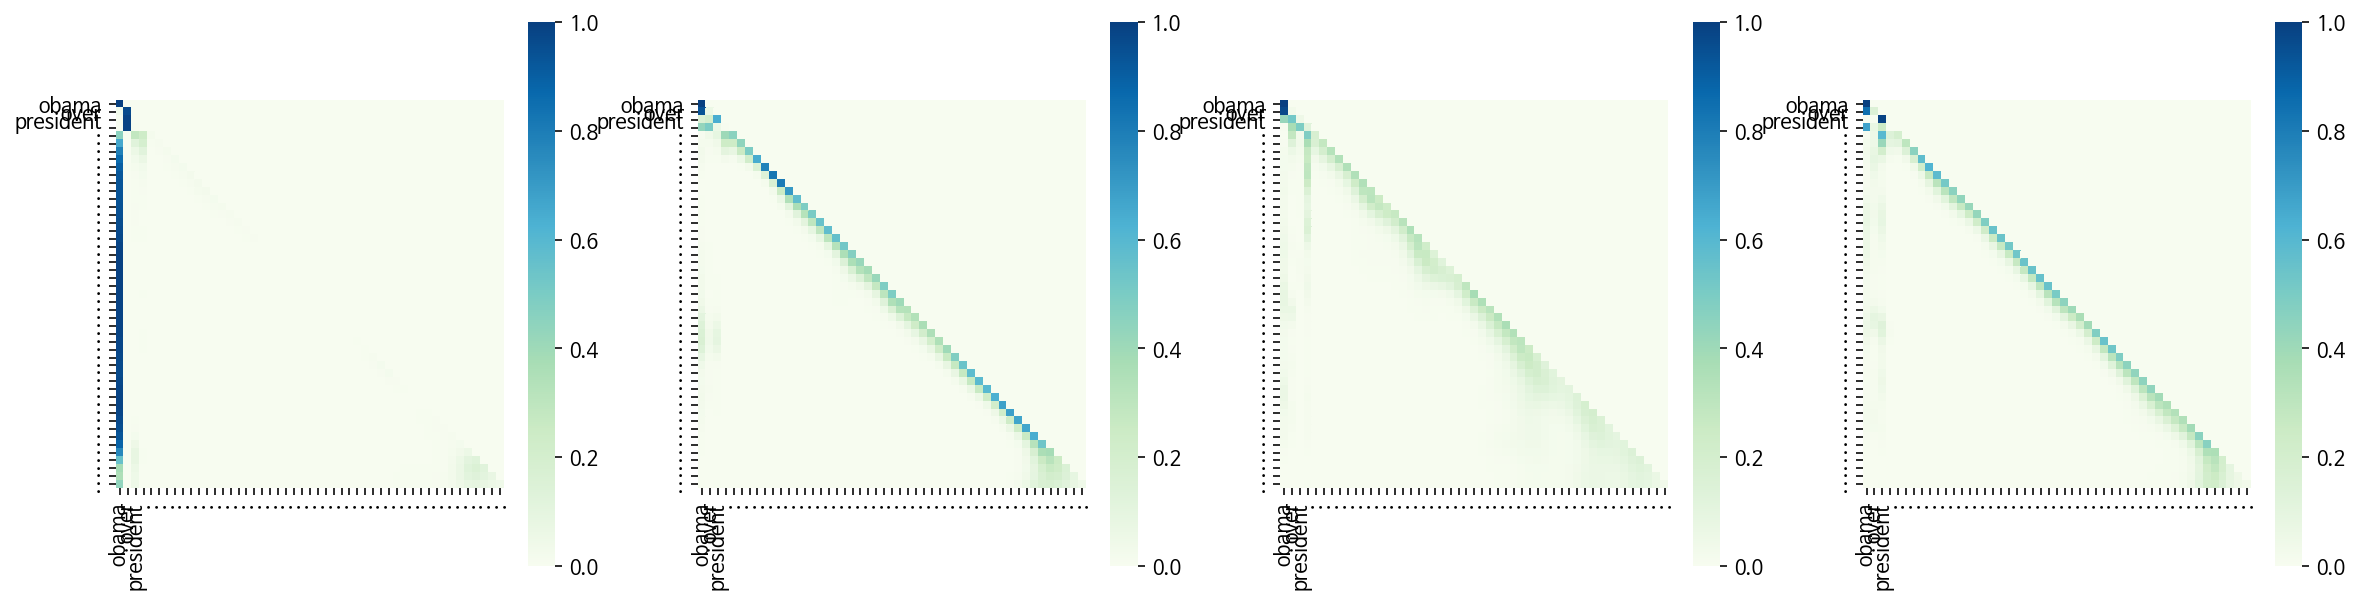

Decoder Src Layer 1


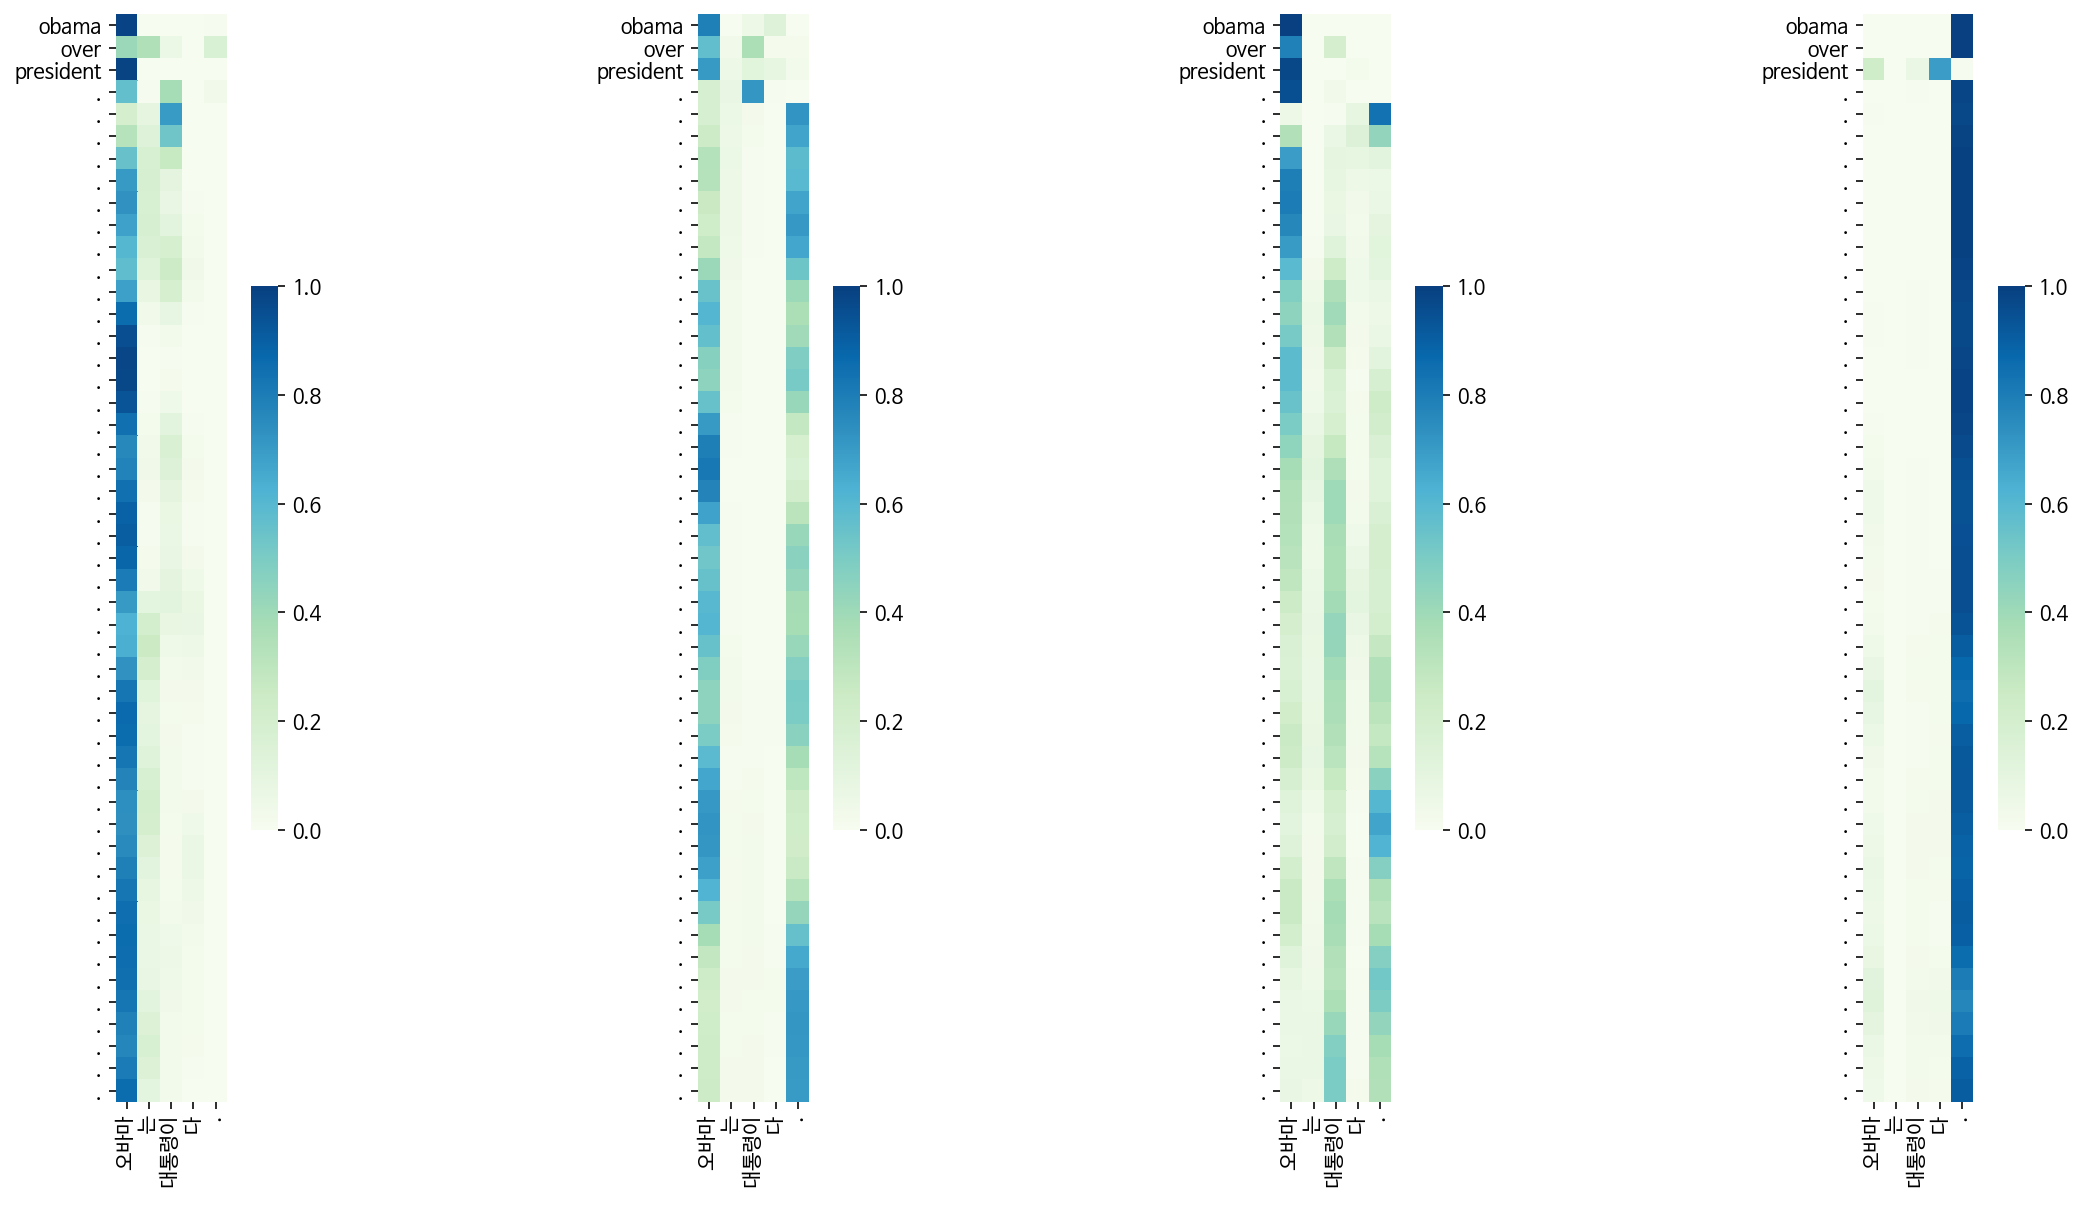

Decoder Self Layer 2


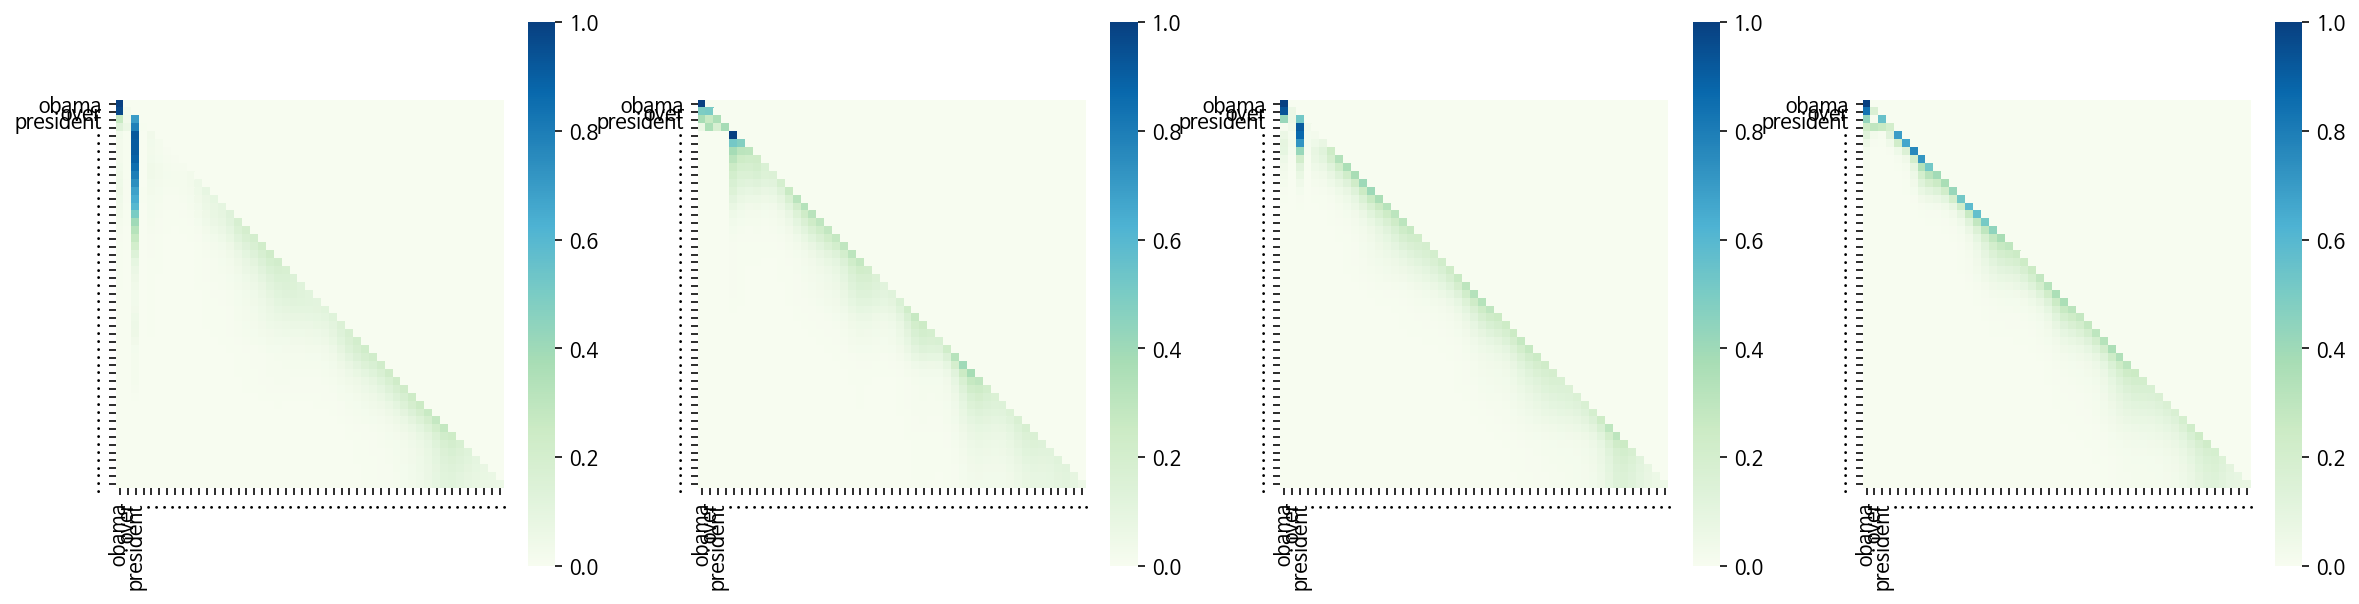

Decoder Src Layer 2


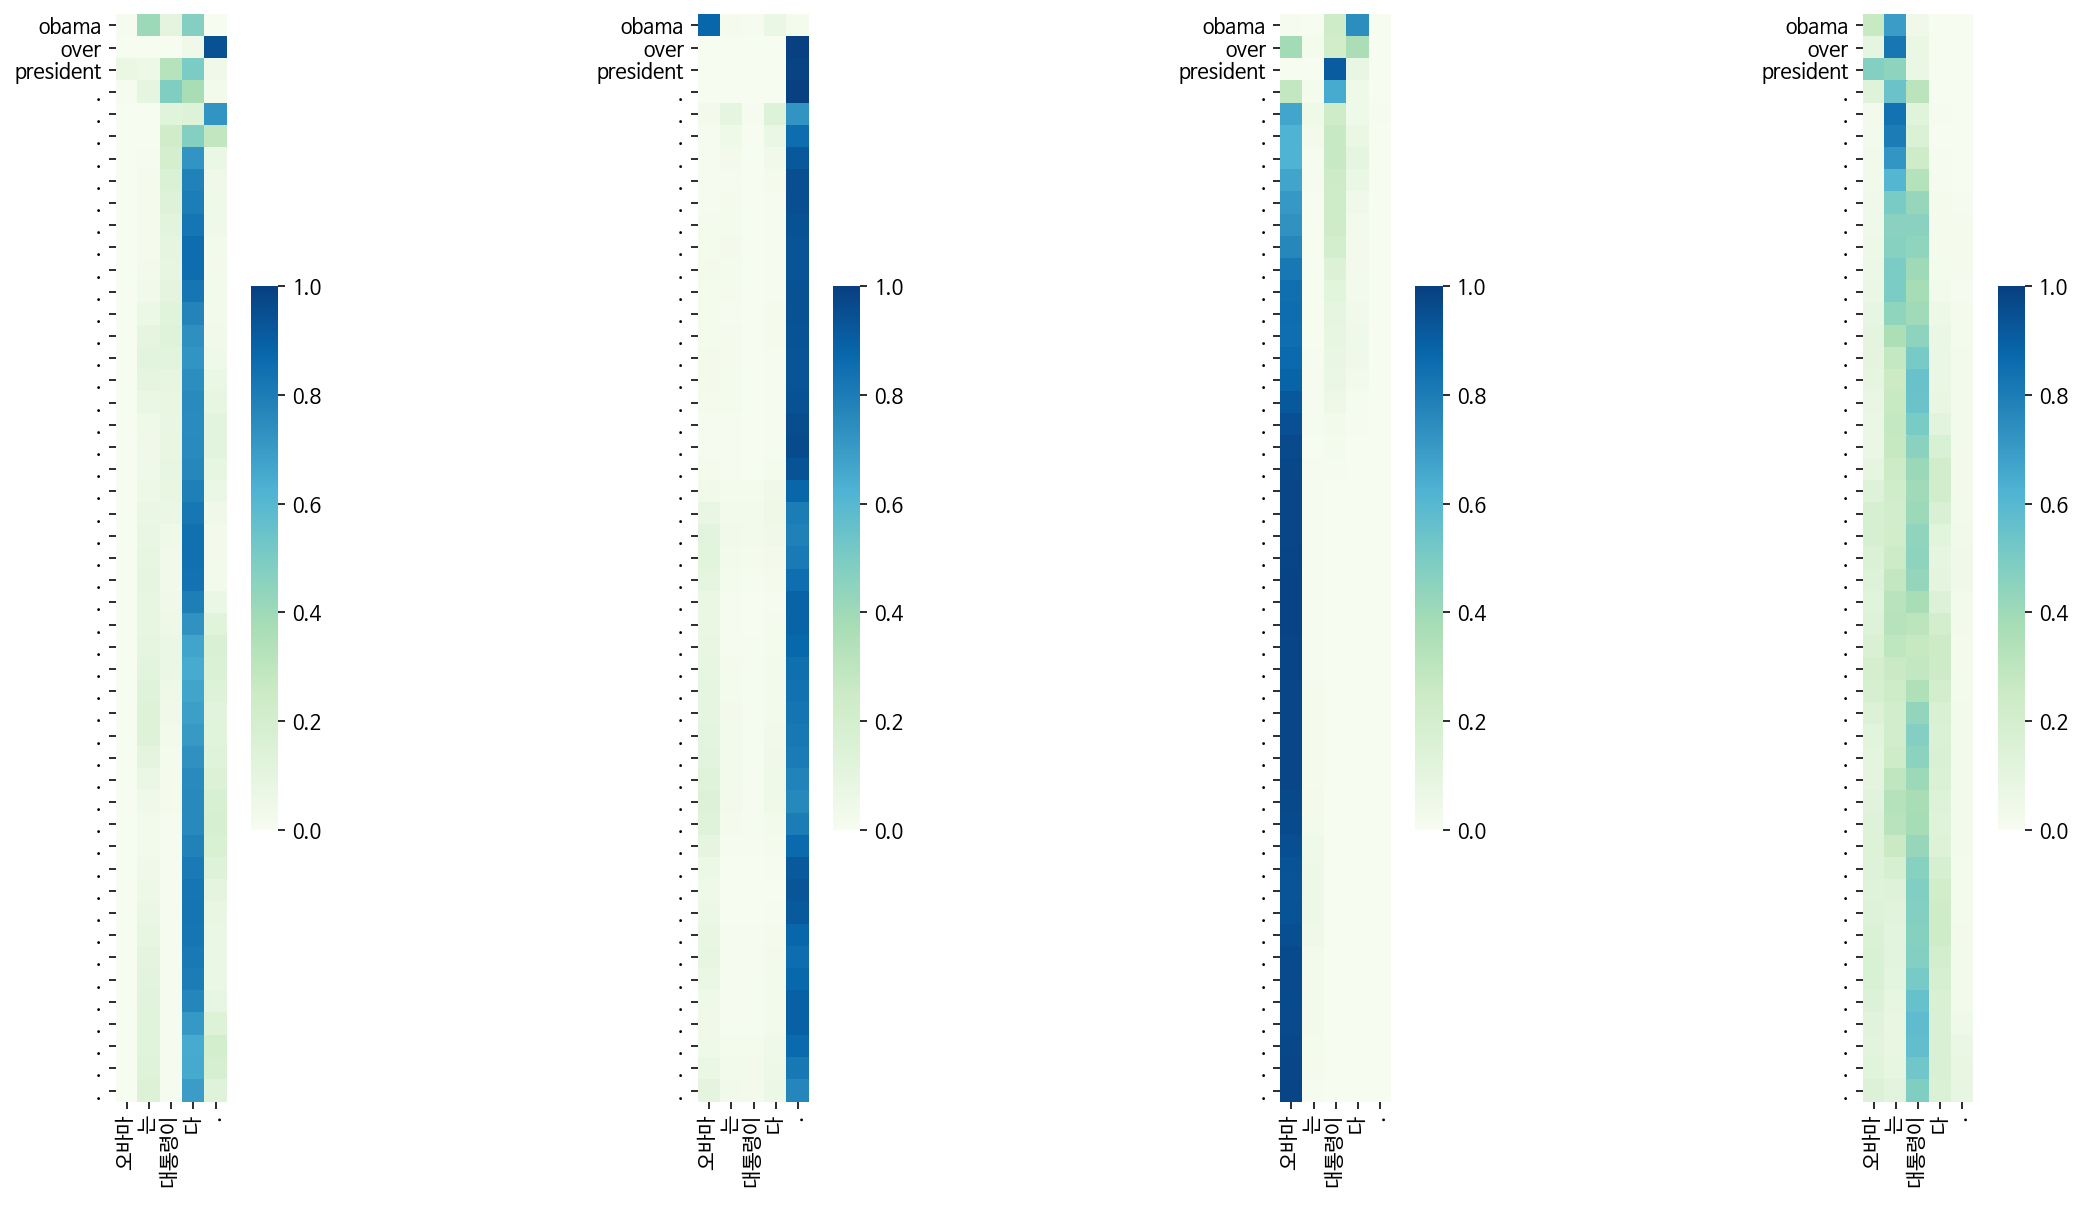

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people over the of of of of of the over . the of of people are . . . . . . . . . of to . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : don any any any coffee no is . no coffee coffee coffee . is not . not coffee . no is . no . . no . . . . coffee is . . . no . . . no . is . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven and people dead seven dead seven and dead were . . and . . . . . . . dead . . deads .s .ss .


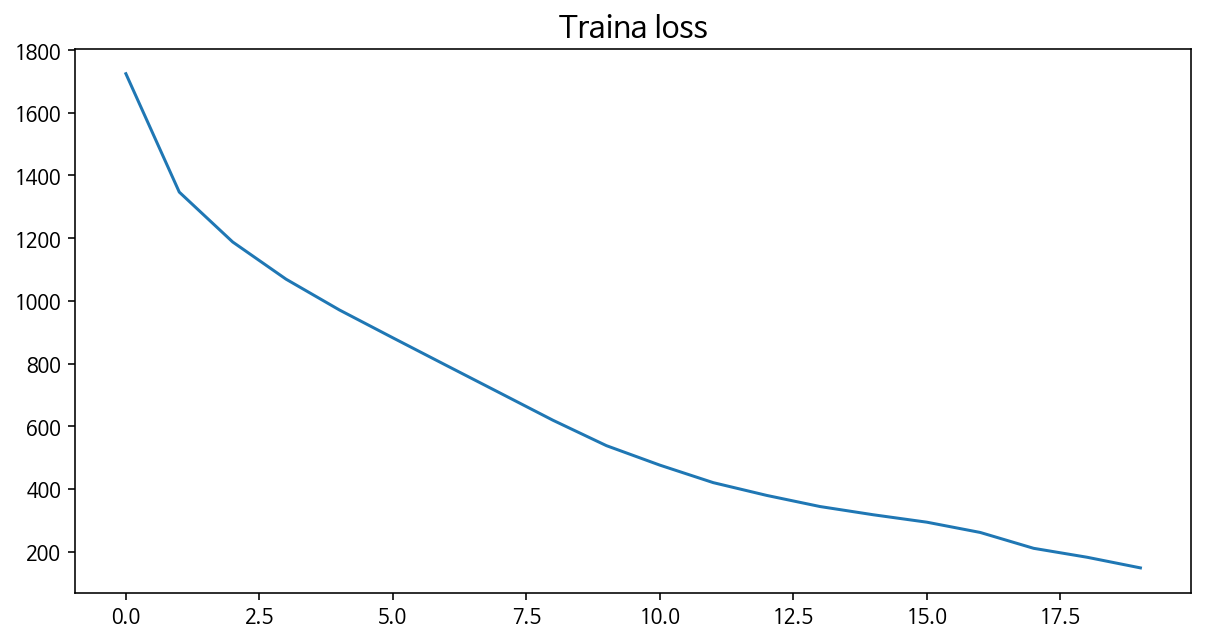

In [306]:
losses = train(transformer, optimizer, enc_train, dec_train, 
               ko_tokenizer, en_tokenizer, examples, 20, 256)
show_train_loss(losses)

## Step 5. 결론
---

### 프로젝트 평가

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다. 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.
    - 전처리 과정이 지시 사항대로 이루어졌다.
2. Transformer 번역기 모델이 정상적으로 구동된다. Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
    - Transformer 모델이 정작적으로 구동되며 학습이 진행되었다
    - 입력으로 한국어 문장을 받아 영어 문장을 출력하는 번역 기능이 정상적으로 작동하였다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다. 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.
    - 핵심단어에 대한 번역은 이루어졌지만, 제대로 된 문장이 생성되지 못하였다.